In [26]:
import pandas as pd
from pybaseball.lahman import *
import matplotlib.pyplot as plt

from pybaseball.retrosheet import *

park_factor = pd.read_csv("datasets/parkfactors.csv")
sal = pd.read_csv("datasets/Salaries.csv")

year = ['park_factor_2014','park_factor_2015','park_factor_2016']
yearID = 2

season = 0
if (yearID == 0):
    season = 2014
elif (yearID == 1):
    season = 2015
elif (yearID == 2):
    season = 2016
games = season_game_logs(season)

teams = teams()

In [27]:
teams2016 = teams.loc[(teams['yearID'] == 2016)]

park_factor = park_factor.rename(columns={'teamID':'home_team'})

#add OBP for home and away teams
games['home_OBP'] = ((games['home_hits'] + games['home_bb'] + games['home_hbp']) / 
                    (games['home_abs'] + games['home_bb'] + games['home_hbp'] + games['home_sac_flies']))
games['visiting_OBP'] = ((games['visiting_hits'] + games['visiting_bb'] + games['visiting_hbp']) / 
                    (games['visiting_abs'] + games['visiting_bb'] + games['visiting_hbp'] + games['visiting_sac_flies']))

#add SLG for home and away games
games['home_SLG'] = ((games['home_hits'] + games['home_doubles'] + (2 * games['home_triples']) + (3 * games['home_homeruns']))
                     / games['home_abs'])
games['visiting_SLG'] = ((games['visiting_hits'] + games['visiting_doubles'] + (2 * games['visiting_triples']) + (3 * games['visiting_homeruns']))
                     / games['visiting_abs'])

#need to merge home team park factor into retrosheet data so that we can use it to calculate adjuste runs
gamesWithParkFactor = pd.merge(games, park_factor[['home_team','name', year[yearID]]], on='home_team', how='left')

#now need to calculate home and away scores based on the park factor they are playing in
gamesWithParkFactor['reverse_park_factor_2016'] = ((1 - gamesWithParkFactor[year[yearID]]) + 1)

gamesWithParkFactor['home_score_adjusted'] = gamesWithParkFactor['home_score'] * gamesWithParkFactor['reverse_park_factor_2016']
gamesWithParkFactor['visiting_score_adjusted'] = gamesWithParkFactor['visiting_score'] * gamesWithParkFactor['reverse_park_factor_2016']

homeTeamsAdjustedScores = gamesWithParkFactor.groupby(['home_team','name']).agg({'park_factor_2016':'mean','home_score':'mean','home_score_adjusted':'mean'}).reset_index()
visitingTeamsAdjustedScores = gamesWithParkFactor.groupby('visiting_team').agg({'visiting_score':'mean','visiting_score_adjusted':'mean'}).reset_index()

adjustedScores = pd.merge(homeTeamsAdjustedScores, visitingTeamsAdjustedScores.rename(columns={'visiting_team':'home_team'}), on='home_team', how='left')

adjustedScores['score_adjusted'] = (adjustedScores['home_score_adjusted'] + adjustedScores['visiting_score_adjusted']) / 2

adjustedScores.head(30).sort_values(by='score_adjusted', ascending=False)


,home_team,name,park_factor_2016,home_score,home_score_adjusted,visiting_score,visiting_score_adjusted,score_adjusted
6,CHN,Cubs,0.874,4.802469,5.407580,5.172840,5.216704,5.312142
25,SLN,Cardinals,0.921,4.382716,4.728951,5.234568,5.312469,5.020710
23,SEA,Mariners,0.941,4.567901,4.837407,4.913580,5.024716,4.931062
4,BOS,Red Sox,1.199,5.888889,4.717000,4.950617,4.952827,4.834914
29,WAS,Nationals,0.956,4.506173,4.704444,4.913580,4.885136,4.794790
11,HOU,Astros,0.808,4.123457,4.915160,4.814815,4.668481,4.791821
13,LAN,Dodgers,0.813,4.320988,5.129012,4.629630,4.389691,4.759352
3,BAL,Orioles,0.953,4.641975,4.860148,4.543210,4.393679,4.626914
0,ANA,Angels,0.910,4.160494,4.534938,4.691358,4.715012,4.624975
10,DET,Tigers,1.019,4.762500,4.672012,4.555556,4.426864,4.549438


In [28]:
#do adjusted OBP
gamesWithParkFactor['home_OBP_adjusted'] = gamesWithParkFactor['home_OBP'] * gamesWithParkFactor['reverse_park_factor_2016']
gamesWithParkFactor['visiting_OBP_adjusted'] = gamesWithParkFactor['visiting_OBP'] * gamesWithParkFactor['reverse_park_factor_2016']

homeTeamsAdjustedOBP = gamesWithParkFactor.groupby('home_team').agg({year[yearID]:'mean','home_OBP':'mean','home_OBP_adjusted':'mean'}).reset_index()
visitingTeamsAdjustedOBP = gamesWithParkFactor.groupby('visiting_team').agg({'visiting_OBP':'mean','visiting_OBP_adjusted':'mean'}).reset_index()

adjustedOBP = pd.merge(homeTeamsAdjustedOBP, visitingTeamsAdjustedOBP.rename(columns={'visiting_team':'home_team'}), on='home_team', how='left')

adjustedOBP['OBP_adjusted'] = (adjustedOBP['home_OBP_adjusted'] + adjustedOBP['visiting_OBP_adjusted']) / 2

adjustedOBP.head(30).sort_values(by='OBP_adjusted', ascending=False)

,home_team,park_factor_2016,home_OBP,home_OBP_adjusted,visiting_OBP,visiting_OBP_adjusted,OBP_adjusted
6,CHN,0.874,0.342158,0.385270,0.329485,0.336132,0.360701
14,MIA,0.834,0.304262,0.354769,0.325437,0.326591,0.340680
11,HOU,0.808,0.305720,0.364418,0.316992,0.310820,0.337619
25,SLN,0.921,0.315786,0.340733,0.318936,0.324401,0.332567
23,SEA,0.941,0.323685,0.342782,0.313761,0.319986,0.331384
13,LAN,0.813,0.315965,0.375051,0.305671,0.287688,0.331369
0,ANA,0.910,0.310135,0.338047,0.316393,0.319430,0.328738
29,WAS,0.956,0.320611,0.334718,0.318619,0.321979,0.328348
21,PIT,1.007,0.337150,0.334790,0.314024,0.321245,0.328017
15,MIL,0.972,0.320557,0.329533,0.310826,0.318203,0.323868


In [29]:
#do adjusted SLG
gamesWithParkFactor['home_SLG_adjusted'] = gamesWithParkFactor['home_SLG'] * gamesWithParkFactor['reverse_park_factor_2016']
gamesWithParkFactor['visiting_SLG_adjusted'] = gamesWithParkFactor['visiting_SLG'] * gamesWithParkFactor['reverse_park_factor_2016']

homeTeamsAdjustedSLG = gamesWithParkFactor.groupby('home_team').agg({year[yearID]:'mean','home_SLG':'mean','home_SLG_adjusted':'mean'}).reset_index()
visitingTeamsAdjustedSLG = gamesWithParkFactor.groupby('visiting_team').agg({'visiting_SLG':'mean','visiting_SLG_adjusted':'mean'}).reset_index()

adjustedSLG = pd.merge(homeTeamsAdjustedSLG, visitingTeamsAdjustedSLG.rename(columns={'visiting_team':'home_team'}), on='home_team', how='left')

adjustedSLG['SLG_adjusted'] = (adjustedSLG['home_SLG_adjusted'] + adjustedSLG['visiting_SLG_adjusted']) / 2

adjustedSLG.head(30).sort_values(by='SLG_adjusted', ascending=False)

,home_team,park_factor_2016,home_SLG,home_SLG_adjusted,visiting_SLG,visiting_SLG_adjusted,SLG_adjusted
25,SLN,0.921,0.422455,0.455829,0.439167,0.447797,0.451813
6,CHN,0.874,0.413955,0.466114,0.424183,0.431316,0.448715
11,HOU,0.808,0.404250,0.481866,0.415174,0.405465,0.443666
23,SEA,0.941,0.422940,0.447894,0.418663,0.427957,0.437926
3,BAL,0.953,0.445495,0.466434,0.422810,0.408374,0.437404
29,WAS,0.956,0.420800,0.439315,0.417788,0.421914,0.430614
26,TBA,0.889,0.406695,0.451839,0.427288,0.405391,0.428615
13,LAN,0.813,0.408779,0.485220,0.386062,0.365442,0.425331
10,DET,1.019,0.442747,0.434335,0.418182,0.405391,0.419863
14,MIA,0.834,0.372350,0.434160,0.399013,0.400776,0.417468


In [30]:
mergedData = pd.merge(adjustedScores, adjustedOBP[['home_team','OBP_adjusted']],on=['home_team'],how='inner')
mergedData = pd.merge(mergedData, adjustedSLG[['home_team','SLG_adjusted']],on=['home_team'],how='inner')
runMean=mergedData['score_adjusted'].mean()
obpMean=mergedData['OBP_adjusted'].mean()
slgMean=mergedData['SLG_adjusted'].mean()
obpFactor=runMean/obpMean
slgFactor=runMean/slgMean
mergedData['Super_Score']=mergedData['score_adjusted']+obpFactor*mergedData['OBP_adjusted']+slgFactor*mergedData['SLG_adjusted']
mergedData=mergedData.sort_values(by=['Super_Score'],ascending=False)
mergedData

,home_team,name,park_factor_2016,home_score,home_score_adjusted,visiting_score,visiting_score_adjusted,score_adjusted,OBP_adjusted,SLG_adjusted,Super_Score
6,CHN,Cubs,0.874,4.802469,5.407580,5.172840,5.216704,5.312142,0.360701,0.448715,15.279250
25,SLN,Cardinals,0.921,4.382716,4.728951,5.234568,5.312469,5.020710,0.332567,0.451813,14.624720
11,HOU,Astros,0.808,4.123457,4.915160,4.814815,4.668481,4.791821,0.337619,0.443666,14.378476
23,SEA,Mariners,0.941,4.567901,4.837407,4.913580,5.024716,4.931062,0.331384,0.437926,14.367358
29,WAS,Nationals,0.956,4.506173,4.704444,4.913580,4.885136,4.794790,0.328348,0.430614,14.108755
13,LAN,Dodgers,0.813,4.320988,5.129012,4.629630,4.389691,4.759352,0.331369,0.425331,14.058471
3,BAL,Orioles,0.953,4.641975,4.860148,4.543210,4.393679,4.626914,0.312806,0.437404,13.795516
0,ANA,Angels,0.910,4.160494,4.534938,4.691358,4.715012,4.624975,0.328738,0.413923,13.762923
14,MIA,Marlins,0.834,3.775000,4.401650,4.358025,4.326704,4.364177,0.340680,0.417468,13.709101
10,DET,Tigers,1.019,4.762500,4.672012,4.555556,4.426864,4.549438,0.315634,0.419863,13.567164


In [31]:
#gets the sal
i=2
sal_year=[2014,2015,2016]#this uses the same year index as we used to change the year above
sal_name=['team_salary_14','team_salary_15','team_salary_16']#this uses the same year index as we used to change the year above
salForSpecificYear = sal.loc[sal['yearID'] == sal_year[i]].copy()
salariesForEachTeam = sal.groupby('teamID')['salary'].sum().reset_index(name=sal_name[i])
salariesForEachTeam = salariesForEachTeam.rename(columns={'teamID':'home_team'})
mergedData = pd.merge(mergedData, salariesForEachTeam[['home_team',sal_name[i]]],on=['home_team'],how='outer')#merged salary data to the big dataset 
mergedData=mergedData.sort_values(by=['Super_Score'],ascending=False).copy()

mergedData

,home_team,name,park_factor_2016,home_score,home_score_adjusted,visiting_score,visiting_score_adjusted,score_adjusted,OBP_adjusted,SLG_adjusted,Super_Score,team_salary_16
0,CHN,Cubs,0.874,4.802469,5.407580,5.172840,5.216704,5.312142,0.360701,0.448715,15.279250,335469478
1,SLN,Cardinals,0.921,4.382716,4.728951,5.234568,5.312469,5.020710,0.332567,0.451813,14.624720,382988000
2,HOU,Astros,0.808,4.123457,4.915160,4.814815,4.668481,4.791821,0.337619,0.443666,14.378476,202266200
3,SEA,Mariners,0.941,4.567901,4.837407,4.913580,5.024716,4.931062,0.331384,0.437926,14.367358,350423139
4,WAS,Nationals,0.956,4.506173,4.704444,4.913580,4.885136,4.794790,0.328348,0.430614,14.108755,429223798
5,LAN,Dodgers,0.813,4.320988,5.129012,4.629630,4.389691,4.759352,0.331369,0.425331,14.058471,654094980
6,BAL,Orioles,0.953,4.641975,4.860148,4.543210,4.393679,4.626914,0.312806,0.437404,13.795516,380324289
7,ANA,Angels,0.910,4.160494,4.534938,4.691358,4.715012,4.624975,0.328738,0.413923,13.762923,379244998
8,MIA,Marlins,0.834,3.775000,4.401650,4.358025,4.326704,4.364177,0.340680,0.417468,13.709101,187207602
9,DET,Tigers,1.019,4.762500,4.672012,4.555556,4.426864,4.549438,0.315634,0.419863,13.567164,520016731


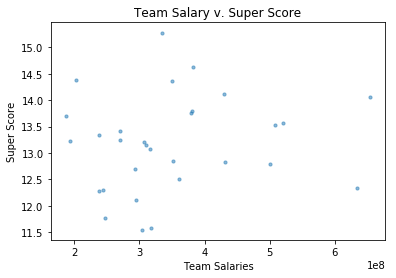

In [32]:
x = mergedData[sal_name[i]]
y = mergedData['Super_Score']

# Plot
plt.scatter(x, y, s=10, alpha=0.5)
plt.title('Team Salary v. Super Score')
plt.xlabel('Team Salaries')
plt.ylabel('Super Score')
plt.show()